## Prestack Kirchoff Migration

##### Written by: Emerald Awuor

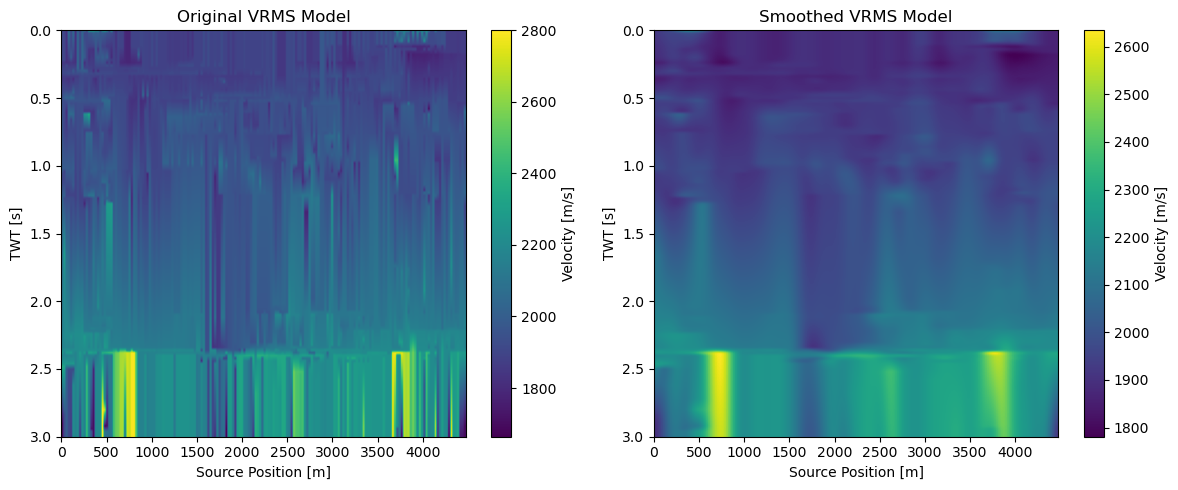

Performing migration...


Migrating Image Points: 100%|██████████| 180/180 [08:47<00:00,  2.93s/it]


In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle


# Define Kirchhoff migration operator
class PrestackKirchhoffMigration:
    def __init__(self, t0, x_source, x_receiver, vrms, dt=0.002):
        self.t0 = t0
        self.dt = dt
        self.x_source = x_source
        self.x_receiver = x_receiver
        self.vrms = vrms
        self.nt0 = len(t0)
        self.nsource = len(x_source)
        self.nreceiver = len(x_receiver)
        
####I have included two forms of the two way travel time equation, either can be used

    # def compute_travel_times(self, ix, isrc, x_image):
    #     """
    #     Compute travel times for a single source and receiver during migration,
    #     adding t0 separately to the source and receiver terms.
    #     """
    #     t0_expanded = self.t0[:, np.newaxis]  # Expand self.t0 to shape (nt0, 1)
        
    #     # Compute source-to-image and image-to-receiver travel times
    #     t_source_to_image = np.sqrt((t0_expanded**2)/4 + (self.x_source[isrc] - x_image[ix])**2 / self.vrms[:, isrc][:, np.newaxis]**2)
    #     t_image_to_receiver = np.sqrt((t0_expanded**2)/4 + (x_image[ix] - self.x_receiver[np.newaxis, :])**2 / self.vrms[:, isrc][:, np.newaxis]**2)
        
    #     # Combine source-to-image and image-to-receiver travel times
    #     t_migration = t_source_to_image + t_image_to_receiver
    #     return t_migration

    def compute_travel_times(self, ix, isrc, x_image):
        """
        Compute travel times using the Double Square Root (DSR) equation with vectorization.
        """
        t0_half_squared = (self.t0 / 2) ** 2  # Half of t0 squared
        scatterpoint = x_image[ix]  # Current scatterpoint (image location)

        # Midpoint (shape: nreceivers,)
        midpoints = (self.x_source[isrc] + self.x_receiver) / 2

        # Horizontal distance x (midpoint to scatterpoint) and h (source-receiver offset)
        x = np.abs(midpoints - scatterpoint)  # Shape: (nreceivers,)
        h = np.abs(self.x_source[isrc] - self.x_receiver) / 2  # Half-offset, shape: (nreceivers,)

        # DSR equation applied vectorized over all receivers
        t_migration = (
            np.sqrt(t0_half_squared[:, np.newaxis] + (x + h) ** 2 / self.vrms[:, isrc][:, np.newaxis] ** 2)
            + np.sqrt(t0_half_squared[:, np.newaxis] + (x - h) ** 2 / self.vrms[:, isrc][:, np.newaxis] ** 2)
        )

        return t_migration


    def apply(self, seismic_volume, x_image):
        """
        Apply Kirchhoff migration for all image locations.
        """
        nimage = len(x_image)
        migrated = np.zeros((self.nt0, nimage))

        for ix in tqdm(range(nimage), desc="Migrating Image Points"):
            for isrc in range(self.nsource):
                gather = seismic_volume[:, isrc, :]  # Shape: (nt, nreceivers)

                # Compute travel times for this source, receiver, and image location
                tt = self.compute_travel_times(ix, isrc, x_image)
                itt = np.floor(tt / self.dt).astype(int)

                # Fractional part
                dtt = (tt / self.dt) - itt

                for ircv in range(self.nreceiver):
                    # Apply valid indices
                    valid_indices = (itt[:, ircv] >= 0) & (itt[:, ircv] < self.nt0 - 1)

                    # Accumulate amplitudes using linear interpolation
                    migrated[valid_indices, ix] += (
                        gather[itt[valid_indices, ircv], ircv] * (1 - dtt[valid_indices, ircv])
                        + gather[itt[valid_indices, ircv] + 1, ircv] * dtt[valid_indices, ircv]
                    )

        return migrated


# Main execution
if __name__ == "__main__":
    # Inputs
    data_file = np.load("input_mdd_volvesynth.npz")
    seismic_volume = data_file["Rinv"]  # Shape: [time, sources, receivers]

    with open("csg_velocity_picks_all.pkl", "rb") as file:
        tmax_section, vrmsmax_section, tmax_c_section, vrmsmax_c_section = pickle.load(file)

    # Define axes
    nt, nsources, nreceivers = seismic_volume.shape
    time = np.linspace(0, 3, nt)
    receivers = np.arange(nreceivers) * 25
    sources = np.arange(nsources) * 25

    # Generate VRMS model
    vrmsmodel = np.zeros((nt, len(vrmsmax_section)))
    for i in range(len(vrmsmax_section)):
        vrmsmodel[:, i] = np.interp(time, tmax_section[i], vrmsmax_section[i])

    # Smooth the velocity model
    from scipy.ndimage import gaussian_filter
    # smoothed_vrmsmodel = vrmsmodel
    smoothed_vrmsmodel = gaussian_filter(vrmsmodel, sigma=3)

    # Visualize velocity model before and after smoothing
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(vrmsmodel, aspect="auto", cmap="viridis", extent=(sources[0], sources[-1], time[-1], time[0]))
    plt.title("Original VRMS Model")
    plt.xlabel("Source Position [m]")
    plt.ylabel("TWT [s]")
    plt.colorbar(label="Velocity [m/s]")
    

    plt.subplot(1, 2, 2)
    plt.imshow(smoothed_vrmsmodel, aspect="auto", cmap="viridis", extent=(sources[0], sources[-1], time[-1], time[0]))
    plt.title("Smoothed VRMS Model")
    plt.xlabel("Source Position [m]")
    plt.ylabel("TWT [s]")
    plt.colorbar(label="Velocity [m/s]")
    plt.tight_layout()
    plt.show()

    # Define image locations (same as receivers in this case)
    image_locations = receivers

    # Initialize Kirchhoff Migrator
    kirchhoff_migrator = PrestackKirchhoffMigration(
        t0=time,
        x_source=sources,
        x_receiver=receivers,
        vrms=smoothed_vrmsmodel,
        dt=time[1] - time[0],
    )

    # Perform Kirchhoff Migration
    print("Performing migration...")
    migrated_image = kirchhoff_migrator.apply(seismic_volume, image_locations)

    # Summed Shot Gather
    shot_gather = np.sum(seismic_volume, axis=1)

    # Plot the shot gather and migrated image side by side
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

    # Plot Shot Gather
    axes[0].imshow(
        shot_gather,
        aspect="auto",
        cmap="seismic",
        extent=(receivers[0], receivers[-1], time[-1], time[0]),
    )
    axes[0].set_title(f"Shot Gather")
    axes[0].set_xlabel("Image Location [m]")
    axes[0].set_ylabel("TWT [s]")
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="seismic"), ax=axes[0])
    cbar.set_label("Amplitude")

    # Plot Migrated Image
    axes[1].imshow(
        migrated_image,
        aspect="auto",
        cmap="gray",
        extent=(image_locations[0], image_locations[-1], time[-1], time[0]),
    )
    axes[1].set_title(f"Migrated Image")
    axes[1].set_xlabel("Image Location [m]")
    axes[1].set_ylabel("TWT [s]")
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axes[1])
    cbar.set_label("Amplitude")

    plt.show()


In [2]:
# Plot the shot gather and migrated image side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Plot Shot Gather
axes[0].imshow(
    shot_gather,
    aspect="auto",
    cmap="gray",
    extent=(receivers[0], receivers[-1], time[-1], time[0]),
)
axes[0].set_title(f"Summed Shot Gather")
axes[0].set_xlabel("Image Position [m]")
axes[0].set_ylabel("TWT [s]")
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axes[0])
cbar.set_label("Amplitude")

# Plot Migrated Image
axes[1].imshow(
    migrated_image,
    aspect="auto",
    cmap="gray",
    extent=(image_locations[0], image_locations[-1], time[-1], time[0]),
)
axes[1].set_title(f"Migrated Image")
axes[1].set_xlabel("Image Location [m]")
axes[1].set_ylabel("TWT [s]")
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axes[1])
cbar.set_label("Amplitude")

# Plot Migrated Image
axes[2].imshow(
    migrated_image-shot_gather,
    aspect="auto",
    cmap="seismic",
    extent=(image_locations[0], image_locations[-1], time[-1], time[0]),
)
axes[2].set_title(f"Migrated Image -Summed shotgather")
axes[2].set_xlabel("Image Location [m]")
axes[2].set_ylabel("TWT [s]")
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="seismic"), ax=axes[2])
cbar.set_label("Amplitude")

plt.show()

Performing migration for source: 20


Migrating Selected Sources: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Performing migration for source: 45


Migrating Selected Sources: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


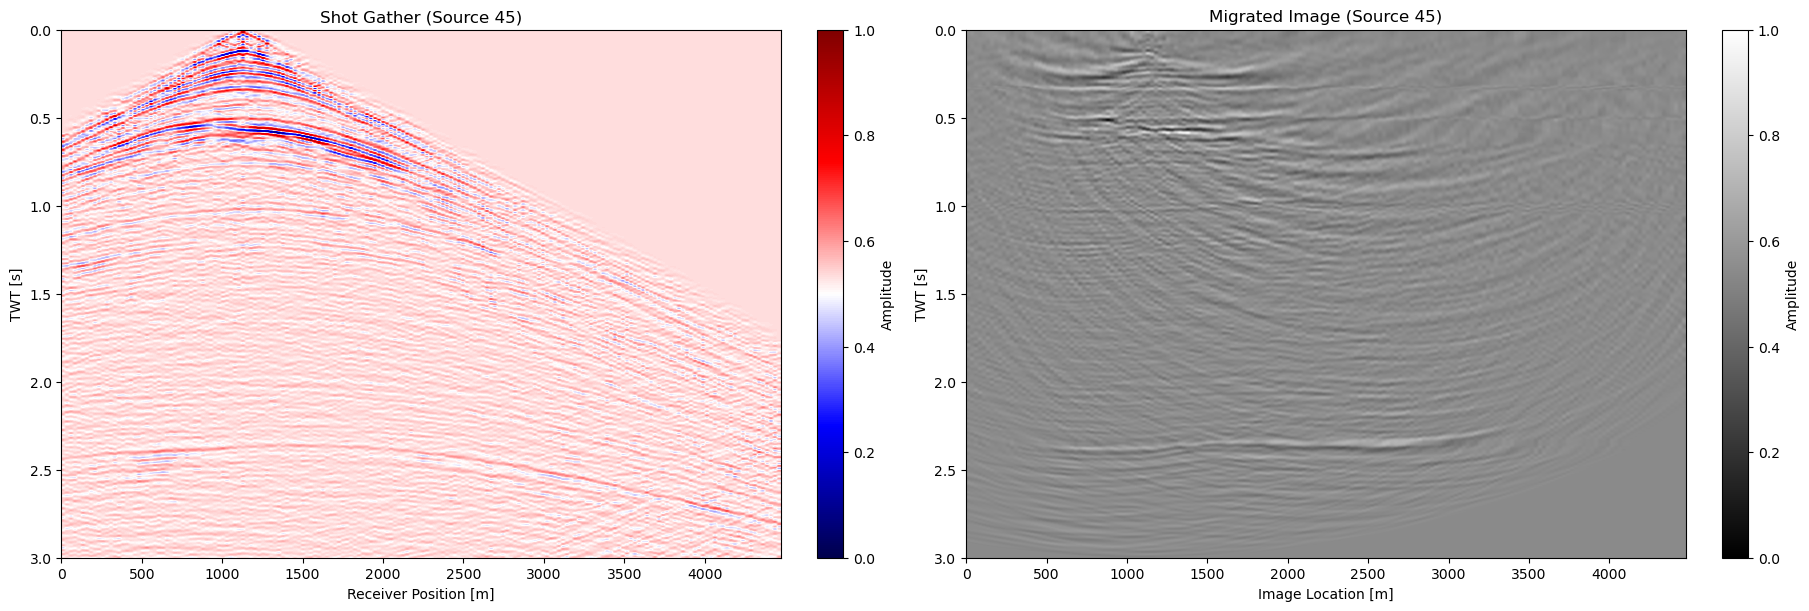

Performing migration for source: 90


Migrating Selected Sources: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


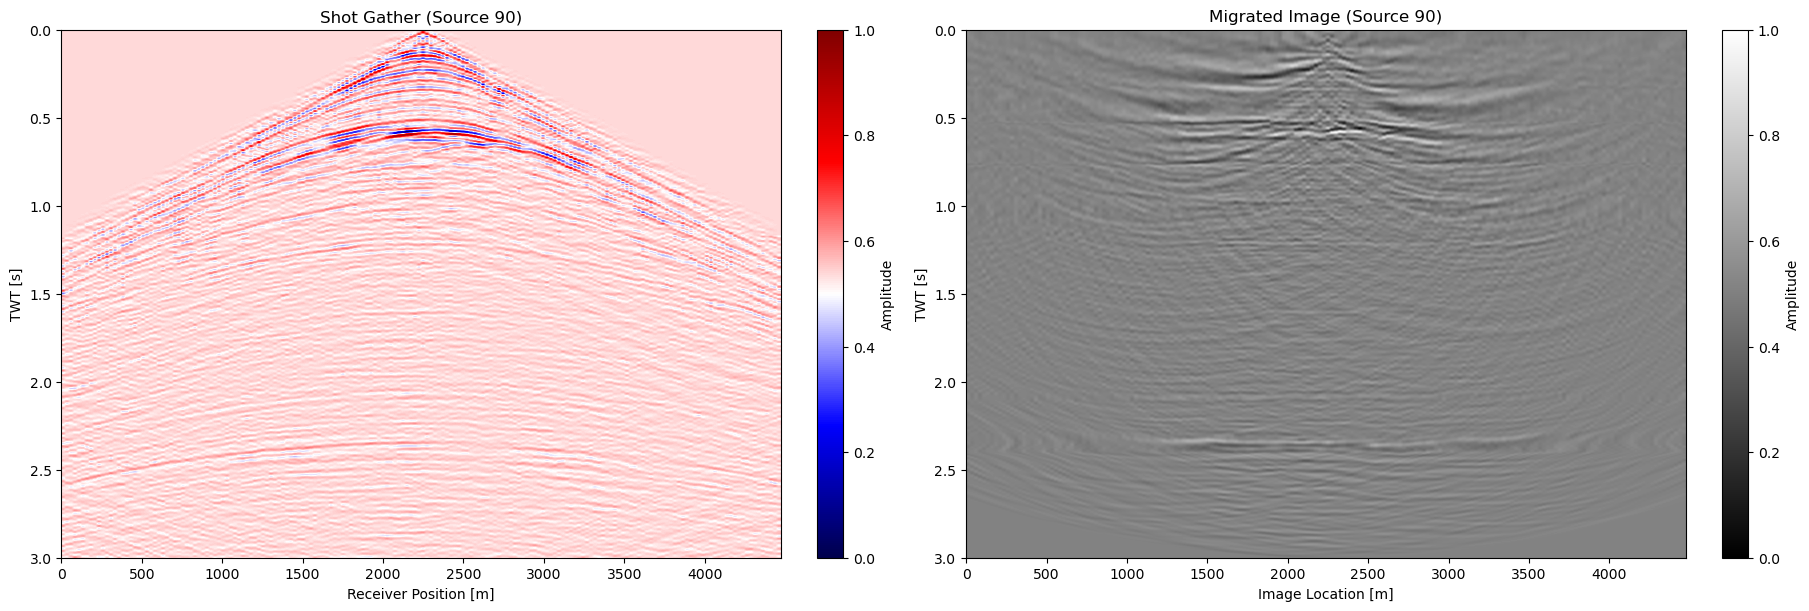

Performing migration for source: 135


Migrating Selected Sources: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


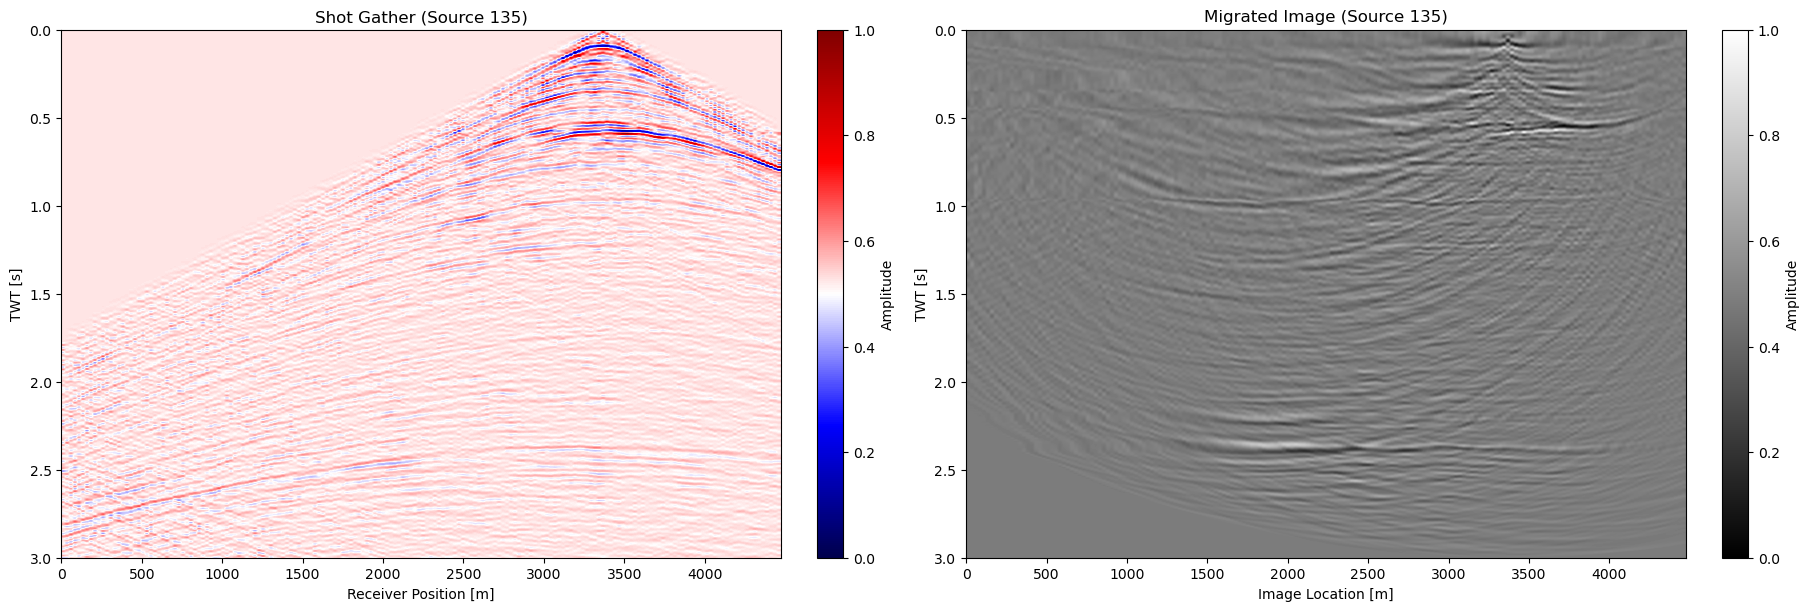

Performing migration for source: 165


Migrating Selected Sources: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


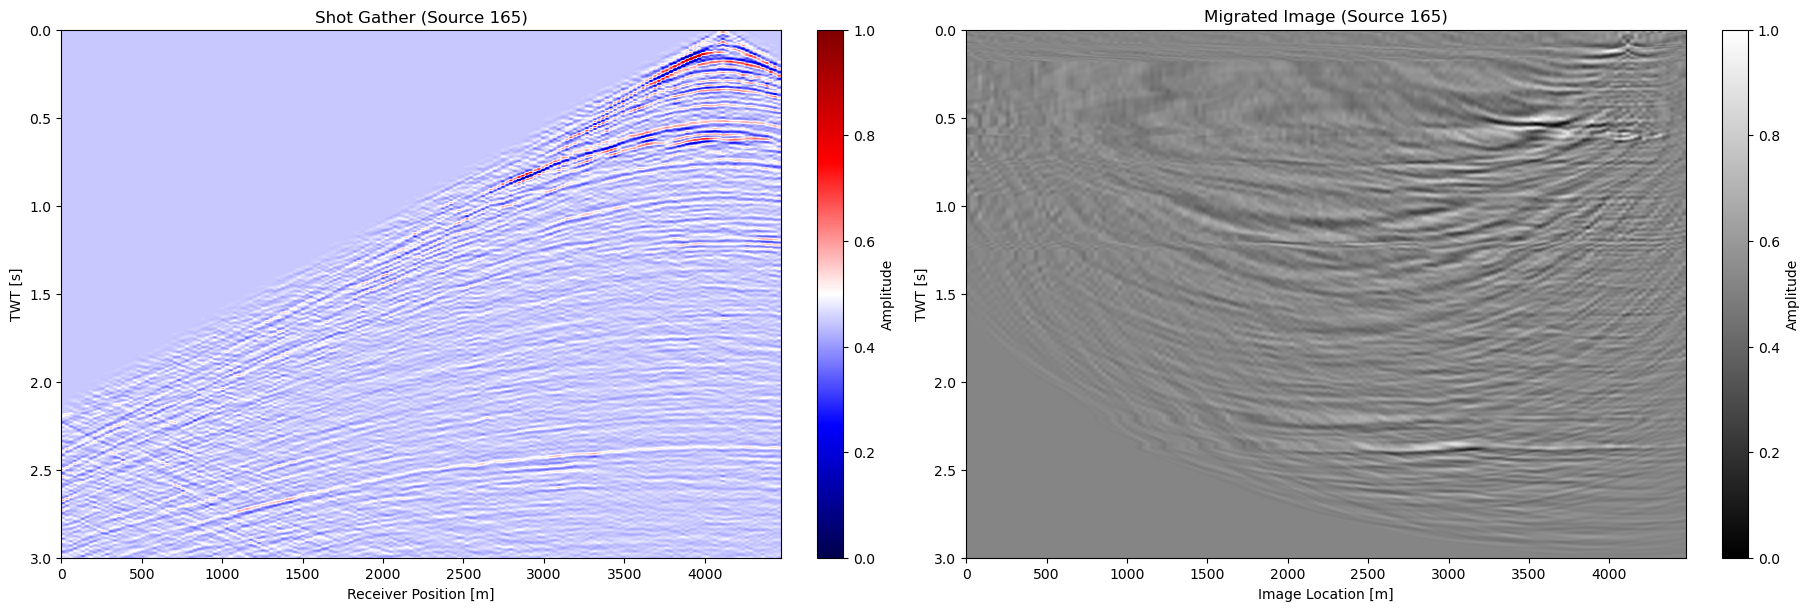

In [3]:
##undertaking migration for specific sources

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import pickle


# Define Kirchhoff migration operator
class PrestackKirchhoffMigration:
    def __init__(self, t0, x_source, x_receiver, vrms, dt=0.002):
        self.t0 = t0
        self.dt = dt
        self.x_source = x_source
        self.x_receiver = x_receiver
        self.vrms = vrms
        self.nt0 = len(t0)
        self.nsource = len(x_source)
        self.nreceiver = len(x_receiver)

    def compute_travel_times(self, ix, isrc, x_image):
        """
        Compute travel times using the Double Square Root (DSR) equation with vectorization.
        """
        t0_half_squared = (self.t0 / 2) ** 2  # Half of t0 squared
        scatterpoint = x_image[ix]  # Current scatterpoint (image location)

        # Midpoint (shape: nreceivers,)
        midpoints = (self.x_source[isrc] + self.x_receiver) / 2

        # Horizontal distance x (midpoint to scatterpoint) and h (source-receiver offset)
        x = np.abs(midpoints - scatterpoint)  # Shape: (nreceivers,)
        h = np.abs(self.x_source[isrc] - self.x_receiver) / 2  # Half-offset, shape: (nreceivers,)

        # DSR equation applied vectorized over all receivers
        t_migration = (
            np.sqrt(t0_half_squared[:, np.newaxis] + (x + h) ** 2 / self.vrms[:, isrc][:, np.newaxis] ** 2)
            + np.sqrt(t0_half_squared[:, np.newaxis] + (x - h) ** 2 / self.vrms[:, isrc][:, np.newaxis] ** 2)
        )

        return t_migration

    def apply(self, seismic_volume, x_image, selected_sources):
        """
        Apply Kirchhoff migration for specific sources.
        """
        nimage = len(x_image)
        migrated = np.zeros((self.nt0, nimage))

        for isrc in tqdm(selected_sources, desc="Migrating Selected Sources"):
            for ix in range(nimage):
                gather = seismic_volume[:, isrc, :]  # Shape: (nt, nreceivers)

                # Compute travel times for this source, receiver, and image location
                tt = self.compute_travel_times(ix, isrc, x_image)
                itt = np.floor(tt / self.dt).astype(int)

                # Fractional part
                dtt = (tt / self.dt) - itt

                for ircv in range(self.nreceiver):
                    # Apply valid indices
                    valid_indices = (itt[:, ircv] >= 0) & (itt[:, ircv] < self.nt0 - 1)

                    # Accumulate amplitudes using linear interpolation
                    migrated[valid_indices, ix] += (
                        gather[itt[valid_indices, ircv], ircv] * (1 - dtt[valid_indices, ircv])
                        + gather[itt[valid_indices, ircv] + 1, ircv] * dtt[valid_indices, ircv]
                    )

        return migrated


# Main execution
if __name__ == "__main__":
    # Load seismic data and VRMS model
    data_file = np.load("input_mdd_volvesynth.npz")
    seismic_volume = data_file["Rinv"]  # Shape: [time, sources, receivers]

    with open("csg_velocity_picks_all.pkl", "rb") as file:
        tmax_section, vrmsmax_section, tmax_c_section, vrmsmax_c_section = pickle.load(file)

    # Define axes
    nt, nsources, nreceivers = seismic_volume.shape
    time = np.linspace(0, 3, nt)
    receivers = np.arange(nreceivers) * 25
    sources = np.arange(nsources) * 25

    # Generate VRMS model
    vrmsmodel = np.zeros((nt, len(vrmsmax_section)))
    for i in range(len(vrmsmax_section)):
        vrmsmodel[:, i] = np.interp(time, tmax_section[i], vrmsmax_section[i])

    # Smooth the velocity model
    smoothed_vrmsmodel = gaussian_filter(vrmsmodel, sigma=5)

    # Define image locations (same as receivers in this case)
    image_locations = receivers

    # Initialize Kirchhoff Migrator
    kirchhoff_migrator = PrestackKirchhoffMigration(
        t0=time,
        x_source=sources,
        x_receiver=receivers,
        vrms=smoothed_vrmsmodel,
        dt=time[1] - time[0],
    )

    # Specify sources to migrate
    selected_sources = [20, 45, 90, 135, 165]

    for source in selected_sources:
        # Perform Kirchhoff Migration
        print(f"Performing migration for source: {source}")
        migrated_image = kirchhoff_migrator.apply(seismic_volume, image_locations, selected_sources=[source])

        # Extract shot gather for selected source
        shot_gather = seismic_volume[:, source, :]

        # Plot the shot gather and migrated image side by side
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

        # Plot Shot Gather
        axes[0].imshow(
            shot_gather,
            aspect="auto",
            cmap="seismic",
            extent=(receivers[0], receivers[-1], time[-1], time[0]),
        )
        axes[0].set_title(f"Shot Gather (Source {source})")
        axes[0].set_xlabel("Receiver Position [m]")
        axes[0].set_ylabel("TWT [s]")
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="seismic"), ax=axes[0])
        cbar.set_label("Amplitude")

        # Plot Migrated Image
        axes[1].imshow(
            migrated_image,
            aspect="auto",
            cmap="gray",
            extent=(image_locations[0], image_locations[-1], time[-1], time[0]),
        )
        axes[1].set_title(f"Migrated Image (Source {source})")
        axes[1].set_xlabel("Image Location [m]")
        axes[1].set_ylabel("TWT [s]")
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axes[1])
        cbar.set_label("Amplitude")

        plt.show()
